In [1]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import seaborn as sns
from typing import Callable
import matplotlib as mpl
import numpy as np

# Apply the default theme
# sns.set_theme()
sns.set_style("whitegrid")
mpl.rcParams["figure.dpi"] = 150

import sys

sys.path.append("..")

from src.data.promptloader import (
    PromptLoader,
    GigawordDataLoader,
    DailymailDataLoader,
    TweetQADataLoader,
    RottenTomatoesDataLoader,
    MMLUAbstractAlgebraDataLoader,
    GSM8KDataLoader,
    MMLUHumanAgingDataLoader,
)
from src.eval.eval_metric import evaluate

plt.rcParams.update({"font.size": 12})
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rcParams.update({
    # 'font.size': 8,
    # 'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

load_dotenv()

True

In [2]:
def get_results(folder: Path, all_reference_data: list[str], use_cached: bool = True):
    

    pred_file = Path(folder) / "predictions.json"

    if not pred_file.is_file():
        print(f"Skipping {str(folder)}")
        return {}
    
    eval_idxs_file = Path(folder) / "eval_idxs.json"
    if eval_idxs_file.is_file():
        ref_data = [all_reference_data[i] for i in json.load(open(eval_idxs_file, "r"))]
    else:
        ref_data = all_reference_data
    
    # Calculate metrics
    return evaluate(pred_file, ref_data, use_cached=use_cached)

In [3]:
def get_results_for_evalset(
    eval_set: str,
    all_ref_data: list[str],
    model_folder_names=["mistral-7b", "llama-7b", "gpt3.5", "gpt4"],
    experiment_path=Path("../experiments/"),
    use_cached: bool = True,
    iterative=True,
    seed = False
):
    results = []
    for model_folder in model_folder_names:
        eval_folder: Path = Path(experiment_path) / model_folder / f"eval_data_{eval_set}"
        if not eval_folder.is_dir():
            print(f"Model: {model_folder} is missing eval set {str(eval_folder)}")
            continue
        
        # extract results in parallel for each in context set
        for in_ctxt_folder in eval_folder.iterdir():
            res = []
            for num_examples_folder in in_ctxt_folder.iterdir():
                f = num_examples_folder / "iterative" if iterative else num_examples_folder
                results_folders = []
                if seed:
                    for seed_folder in f.iterdir():
                        if not seed_folder.is_dir():
                            continue
                        if not "seed" in seed_folder.name:
                            continue
                        results_folders.append(seed_folder)
                else:
                    results_folders.append(f)
                    
                for res_folder in results_folders:
                    try:
                        res.append(get_results(res_folder, all_ref_data, use_cached=use_cached))
                    except Exception as e:
                        print(f"Error processing {str(res_folder)}")
                        print(e)


            res = [r for r in res if r]
            results.extend(res)
    return results

In [4]:
# Assign colors to incontext_set

# Load pastel colors
pastel_colors = sns.color_palette("Set2", 7)
# print(pastel_colors)

dataset_color = {
    "tweetqa": pastel_colors[0],
    "gigaword": pastel_colors[1],
    "dailymail": pastel_colors[2],
    "rotten_tomatoes": pastel_colors[3],
    "mmluaa": pastel_colors[4],
    "gsm8k": pastel_colors[5],
    "mmlu-age": pastel_colors[6],
}

dataset_label = {
    "tweetqa": "TweetQA",
    "gigaword": "Gigaword",
    "dailymail": "Dailymail",
    "rotten_tomatoes": "Rotten Tomatoes",
    "mmluaa": "MMLU Abstract Algebra",
    "gsm8k": "GSM8K",
    "mmlu-age": "MMLU Human Aging",
}

model_label = {
    "mistral-7b": "Mistral-7B",
    "llama-7b": "Llama-7B",
    "gpt3.5": "GPT-3.5",
    "gpt4": "GPT-4",
    "mixtral": "Mixtral",
}

In [5]:
def plot_df_metrics_per_model(
  results_df: pd.DataFrame,
  metrics: list[str],
  x="num_examples",
  save_path: Path = None,
  title: str = None,
  adjust_func: Callable = lambda _: _,
  eval_set: str = "",
  legend_anchor: tuple[float, float] = (0.95, 1.5),
  legend_axs = (-1, 0),
  xlim: tuple = (0, 6),
  legend_rows: int = 2,
  save_png: bool = False,
  fig_xlabel= r'Conversation History Length $L$',
):
    """Plot metrics for each dataset and model
    
    axis per model
    line per dataset

    x-axis: number of examples
    y-axis: metric
    """
    for metric in metrics:
        assert metric in results_df.columns, f"Metric {metric} not in dataframe"

    num_metrics = len(metrics)
    num_models = len(results_df["model"].unique())
    fig, axs = plt.subplots(
        figsize=(12.5, 2 * num_metrics), 
        nrows=num_metrics, 
        ncols=num_models, 
        sharex=True, 
        sharey='row', 
        squeeze=False,
    )

    for y_idx, (metric, axs_y) in enumerate(zip(metrics, axs)):
        for x_idx, (ax, (model, df)) in enumerate(zip(axs_y, results_df.groupby("model"))):
            for (inctxt, df_inctxt) in df.groupby("incontext_set"):
                df_inctxt = df_inctxt.sort_values("num_examples")

                g = sns.lineplot(
                    data=df_inctxt,
                    x=x,
                    y=metric,
                    ax=ax,
                    label=dataset_label[inctxt],
                    color=dataset_color[inctxt],
                    marker="X",
                    errorbar=("pi", 100)
                )

                # Remove ylabel
                # ax.set_ylabel("")
                # if x_idx == 0:
                #     ax.set_ylabel(metric)

                ax.yaxis.set_tick_params(labelbottom=True)
                
                if y_idx == 0:
                    ax.set_title(model_label[model])
                ax.legend_.remove()

            ax.set_xlim(xlim)
            # ax.set_xlabel(r"History Length $L$")
            ax.set_xlabel("")

    # Add legend
    # plot_dataset_models_legend(axs[-1, 0])
    legend = axs[legend_axs].legend(
        loc="upper left", 
        bbox_to_anchor=legend_anchor, 
        ncol=len(results_df["incontext_set"].unique()) // legend_rows,
        # nrow=2,
        fancybox=True,
        shadow=True,
    )
    legend.set_title("Conversation History Task")
    # Colour eval set label
    if eval_set:
        for text in legend.get_texts():
            if text.get_text() == dataset_label[eval_set]:
                # make bold
                # text.set_weight("bold")
                # text.set_color("red")
                text.set_text(rf"\textbf{{{text.get_text()}}}")
    if title:
        fig.suptitle(title)
    # plt.tight_layout()
    adjust_func(axs)
    fig.text(0.5, -0.1, fig_xlabel, ha='center')
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        # Also save as png
        if save_png:
            plt.savefig(save_path.with_suffix(".png"), bbox_inches="tight")
    plt.show()
            

In [59]:
def df_metric_pct_change(df: pd.DataFrame, metric: str):
    """Calculate the percentage change of a metric"""
    df[f"{metric}_pct_change"] = 0.
    for row in df[["model", "incontext_set", metric]].itertuples():
        try:
            baseline_metric = df[(df["model"] == row.model) & (df["incontext_set"] == row.incontext_set) & (df["num_examples"] == 0)][metric].values[0]
            df.loc[row.Index, f"{metric}_pct_change"] = (row[-1] - baseline_metric) / baseline_metric * 100
        except Exception as e:
            print(e)
            print(row)
    return df

In [64]:
def results_markdown_table(
    df: pd.DataFrame,
    metrics: list[str],
    task: str,
    num_examples: int = 6,
):
    """
    Create a markdown table of results
    Format: | dataset | model | metric1 | std |
    NOTE: first row block is for the task
    """
    # sort datasets
    datasets = sorted(list(df["incontext_set"].unique()))
    datasets.remove(task)
    datasets = [task] + datasets # put task first

    table = ""
    
    # header
    table += "| CH-Task | Model | " + " | ".join([f"Mean {m} | {m} Std" for m in metrics]) + " |\n"
    table += "| --- | --- " + " | --- | ---" * len(metrics) + " |\n"

    for dataset in datasets:
        for model in sorted(df["model"].unique()):
            table += f"| {dataset_label[dataset]} | {model_label[model]} "
            for metric in metrics:
                df_model = df[(df["model"] == model) & (df["incontext_set"] == dataset)]
                df_model = df_model[df_model["num_examples"] == num_examples]
                mean = df_model[metric].mean()
                std = df_model[metric].std()
                table += f"| {mean:.2f} | {std:.2f} "
            table += "|\n"

    return table

In [83]:
def markdown_task_distance_rank(df: pd.DataFrame, metric: str, ranks):
  """
  Format: | CH Task | Rank | metric for Model | metric for Model | 
  """
  
  table = ""

  models = sorted(list(df["model"].unique()))
  
  # header
  table += "| CH Task | Rank | " + " | ".join([f"{model_label[mod]}" for mod in models]) + " |\n"
  table += "| --- | --- " + " | --- | ---" * len(models) + " |\n"

  for dataset, rank in ranks.items():
    table += f"| {dataset_label[dataset]} | {rank} "
    for model in models:
      df_model = df[(df["model"] == model) & (df["incontext_set"] == dataset)]
      mean = df_model[metric].mean()
      # std = df_model[metric].std()
      table += f"| {mean:.2f} "
      # table += f"| {mean:.2f} | {std:.2f} "
    table += "|\n"
    
  return table

In [150]:
def markdown_task_distance(df: pd.DataFrame, metric: str, rank_col: str):
  """
  Format: | CH Task | CH Task Length (\# Tokens) | metric for Model | metric for Model | 
  """
  table = ""

  models = sorted(list(df["model"].unique()))

  # Take the mean of the rank col and sort to get CH task order
  ranks = df.groupby("incontext_set")[rank_col].mean().sort_values()

  # header
  table += "| CH Task | CH Task Length (# Tokens) | " + " | ".join([f"{model_label[mod]}" for mod in models]) + " |\n"
  table += "| --- | --- " + " | --- | ---" * len(models) + " |\n"

  for dataset, token_length in ranks.items():
    table += f"| {dataset_label[dataset]} | {token_length:.0f} "
    for model in models:
      df_model = df[(df["model"] == model) & (df["incontext_set"] == dataset)]
      mean = df_model[metric].mean()
      # std = df_model[metric].std()
      table += f"| {mean:.2f} "
      # table += f"| {mean:.2f} | {std:.2f} "
    table += "|\n"

  return table
  

### Evaluate on RT

In [65]:
rt = RottenTomatoesDataLoader()
rt_reference_data = rt.load_test_reference()
rt_results = get_results_for_evalset(
    "rotten_tomatoes",
    rt_reference_data,
    use_cached=False,
    iterative=True,
    seed=True,
)
rt_results_df = pd.DataFrame.from_records(rt_results)
rt_results_df.head()

,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length
0,948,15,1066,100,mistral-7b,rotten_tomatoes,3,None,None,None,327.220450,99.798311,11.084428,438.103189
1,947,15,1066,1000,mistral-7b,rotten_tomatoes,3,None,None,None,325.981238,99.798311,11.209193,436.988743
2,946,14,1066,10000,mistral-7b,rotten_tomatoes,3,None,None,None,327.063790,99.798311,11.121951,437.984053
3,957,11,1066,100,mistral-7b,rotten_tomatoes,6,None,None,None,653.592871,99.798311,11.157598,764.548780
4,954,13,1066,1000,mistral-7b,rotten_tomatoes,6,None,None,None,652.702627,99.798311,11.119137,763.620075


In [66]:
df = rt_results_df
df["acc"] = df["matches"] / df["total"]
df = df_metric_pct_change(df, "acc")

# df.groupby(["model", "incontext_set", "num_examples"]).mean()

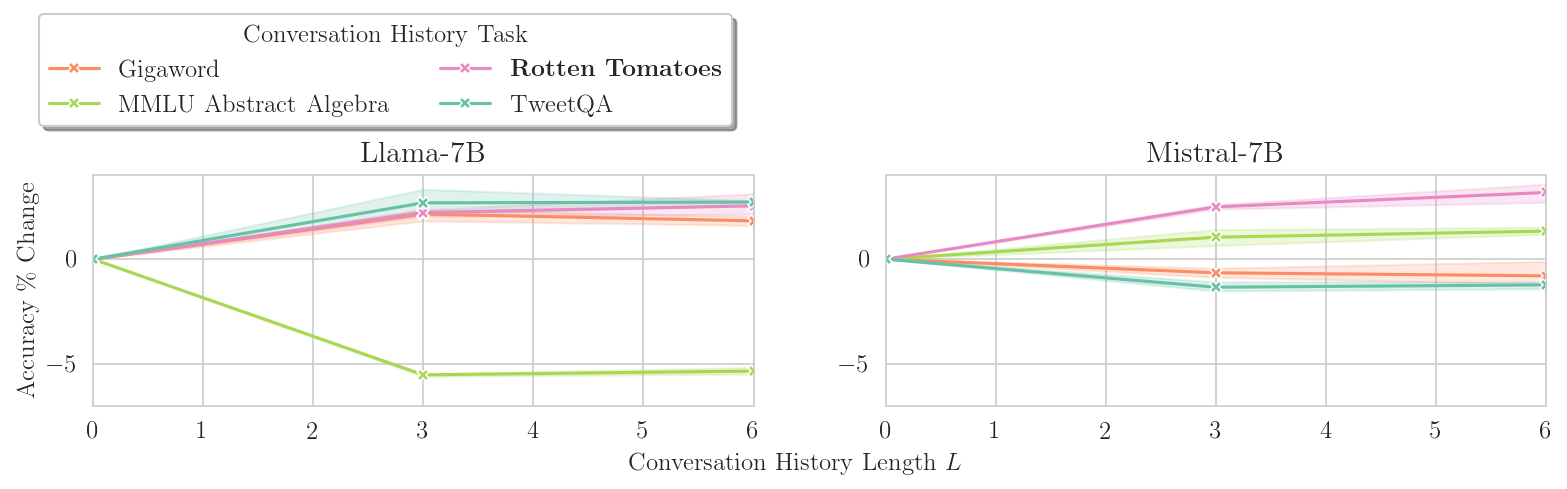

In [67]:
label = r"Accuracy \% Change"
df = rt_results_df.rename(columns={"acc_pct_change": label})
plot_df_metrics_per_model(
  df, 
  [label], 
  # save_path=Path("rt/accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="rotten_tomatoes",
  legend_anchor=(-1.3, 1.75),
  adjust_func=lambda axs: axs[0, 0].set_ylim(-7, 4),
  legend_axs=(-1, 1),
  # save_png=True,
)

In [69]:
print(results_markdown_table(df, [label], "rotten_tomatoes"))

| CH-Task | Model | Mean Accuracy \% Change | Accuracy \% Change Std |
| --- | ---  | --- | --- |
| Rotten Tomatoes | Llama-7B | 2.54 | 0.51 |
| Rotten Tomatoes | Mistral-7B | 3.17 | 0.44 |
| Gigaword | Llama-7B | 1.82 | 0.21 |
| Gigaword | Mistral-7B | -0.79 | 0.60 |
| MMLU Abstract Algebra | Llama-7B | -5.33 | 0.16 |
| MMLU Abstract Algebra | Mistral-7B | 1.33 | 0.17 |
| TweetQA | Llama-7B | 2.72 | 0.12 |
| TweetQA | Mistral-7B | -1.23 | 0.17 |



### Distance Metric: Format (MCQ, Essay)

RT, MMLU, TweetQA, Gigaword

Results df: num_examples, inctxt, model, (seed), 

In [87]:
df = rt_results_df

# remove num_examples == 0
df = df[df["num_examples"] > 0]

ranks = {
  "rotten_tomatoes": 1,
  "mmluaa": 2,
  "tweetqa": 3,
  "gigaword": 4,
}
df["inctxt_rank"] = df["incontext_set"].apply(lambda inctxt: ranks[inctxt])
df.head()

/tmp/ipykernel_41368/3509718076.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["inctxt_rank"] = df["incontext_set"].apply(lambda inctxt: ranks[inctxt])


,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length,acc,acc_pct_change,inctxt_rank
0,948,15,1066,100,mistral-7b,rotten_tomatoes,3,None,None,None,327.220450,99.798311,11.084428,438.103189,0.889306,2.597403,1
1,947,15,1066,1000,mistral-7b,rotten_tomatoes,3,None,None,None,325.981238,99.798311,11.209193,436.988743,0.888368,2.489177,1
2,946,14,1066,10000,mistral-7b,rotten_tomatoes,3,None,None,None,327.063790,99.798311,11.121951,437.984053,0.887430,2.380952,1
3,957,11,1066,100,mistral-7b,rotten_tomatoes,6,None,None,None,653.592871,99.798311,11.157598,764.548780,0.897749,3.571429,1
4,954,13,1066,1000,mistral-7b,rotten_tomatoes,6,None,None,None,652.702627,99.798311,11.119137,763.620075,0.894934,3.246753,1


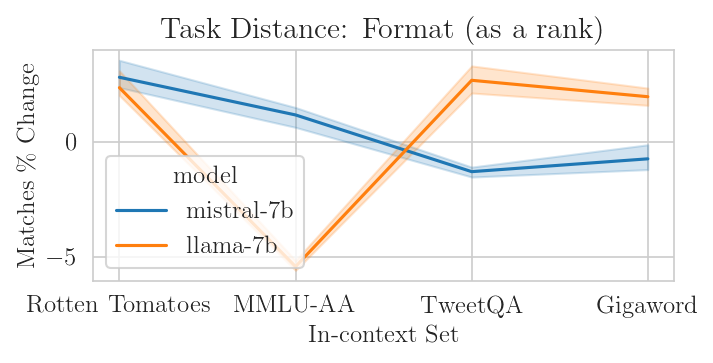

In [88]:
# plot rank against matches_pct_change
fig, ax = plt.subplots(figsize=(5, 2))
sns.lineplot(
    data=df,
    x="inctxt_rank",
    y="acc_pct_change",
    hue="model",
    ax=ax,
    errorbar=("pi", 100),
)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["Rotten Tomatoes", "MMLU-AA", "TweetQA", "Gigaword"])
# rotate xlabels
# plt.xticks(rotation=10)
ax.set_xlabel("In-context Set")
ax.set_ylabel(r"Matches \% Change")
ax.set_title("Task Distance: Format (as a rank)")
plt.show()

In [89]:
metric = "acc_pct_change"
print("Metric: ", metric)
print(markdown_task_distance_rank(rt_results_df, metric, ranks))

Metric:  acc_pct_change
| CH Task | Rank | Llama-7B | Mistral-7B |
| --- | ---  | --- | --- | --- | --- |
| Rotten Tomatoes | 1 | 1.59 | 1.89 |
| MMLU Abstract Algebra | 2 | -3.61 | 0.79 |
| TweetQA | 3 | 1.80 | -0.85 |
| Gigaword | 4 | 1.32 | -0.48 |



### MMLU AA

In [57]:
aa = MMLUAbstractAlgebraDataLoader()
aa_ref_data = aa.load_test_reference()
aa_results = get_results_for_evalset(
    "mmluaa",
    aa_ref_data,
    use_cached=False,
    iterative=True,
    seed=True,
)
aa_results_df = pd.DataFrame(aa_results)

print(len(aa_results_df))
aa_results_df.head()

Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_3/iterative/seed_100/base_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_3/iterative/seed_100/final_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_3/iterative/seed_100/ref_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_3/iterative/seed_1000/base_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_3/iterative/seed_1000/final_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_3/iterative/seed_1000/ref_probabi

,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length
0,26,0,100,100,mistral-7b,rotten_tomatoes,3,None,None,None,328.45,136.44,11.11,476.00
1,27,0,100,1000,mistral-7b,rotten_tomatoes,3,None,None,None,328.31,136.44,11.11,475.86
2,23,0,100,10000,mistral-7b,rotten_tomatoes,3,None,None,None,324.05,136.44,11.08,471.57
3,26,0,100,100,mistral-7b,rotten_tomatoes,6,None,None,None,653.10,136.44,11.11,800.65
4,27,0,100,1000,mistral-7b,rotten_tomatoes,6,None,None,None,657.74,136.44,11.11,805.29


In [62]:
aa_results_df[aa_results_df["model"] == "gpt3.5"]

,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length,acc,acc_pct_change
74,32,0,100,100,gpt3.5,rotten_tomatoes,6,None,None,None,NaN,NaN,NaN,NaN,0.32,-3.030303
75,34,1,100,1000,gpt3.5,rotten_tomatoes,6,None,None,None,NaN,NaN,NaN,NaN,0.34,3.030303
76,35,0,100,10000,gpt3.5,rotten_tomatoes,6,None,None,None,NaN,NaN,NaN,NaN,0.35,6.060606
77,33,2,100,100,gpt3.5,rotten_tomatoes,0,None,None,None,NaN,NaN,NaN,NaN,0.33,0.000000
78,38,0,100,100,gpt3.5,mmluaa,6,None,None,None,NaN,NaN,NaN,NaN,0.38,15.151515
79,37,0,100,1000,gpt3.5,mmluaa,6,None,None,None,NaN,NaN,NaN,NaN,0.37,12.121212
80,41,0,100,10000,gpt3.5,mmluaa,6,None,None,None,NaN,NaN,NaN,NaN,0.41,24.242424
81,33,2,100,100,gpt3.5,mmluaa,0,None,None,None,NaN,NaN,NaN,NaN,0.33,0.000000
82,24,3,100,100,gpt3.5,tweetqa,6,None,None,None,NaN,NaN,NaN,NaN,0.24,-27.272727
83,27,3,100,1000,gpt3.5,tweetqa,6,None,None,None,NaN,NaN,NaN,NaN,0.27,-18.181818


In [60]:
aa_results_df["acc"] = aa_results_df["matches"] / aa_results_df["total"]
aa_results_df = df_metric_pct_change(aa_results_df, "acc")

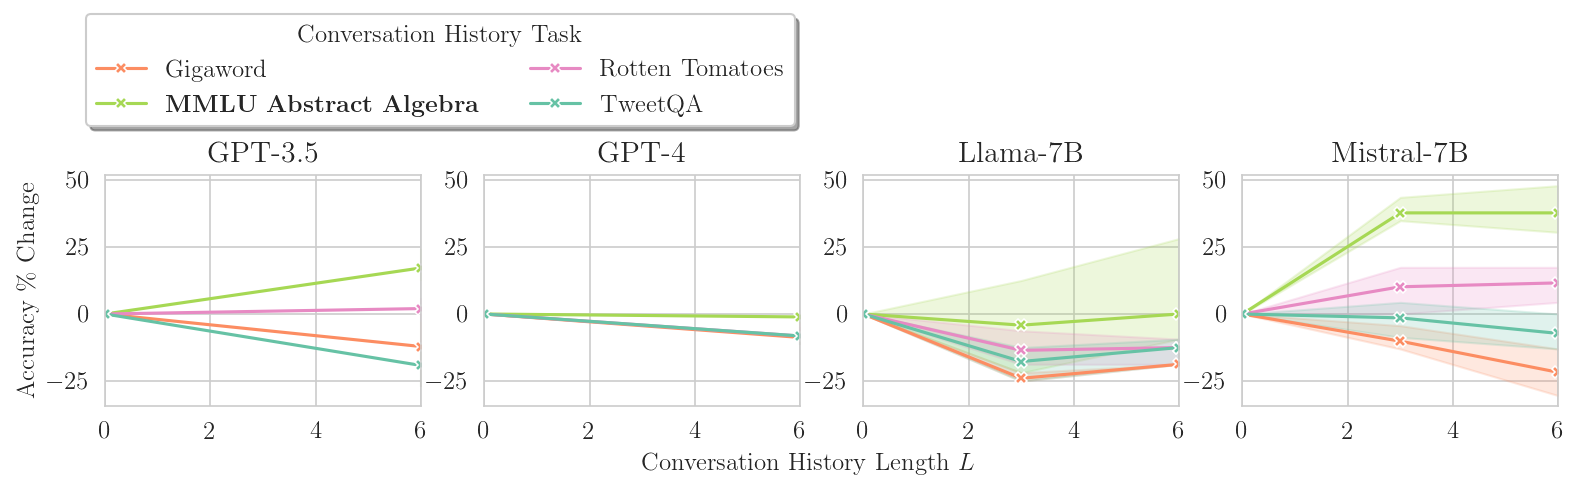

In [61]:
label = r"Accuracy \% Change"
df = aa_results_df.rename(columns={"acc_pct_change": label})
plot_df_metrics_per_model(
  df, 
  [label], 
  # save_path=Path("rt/accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmluaa",
  legend_anchor=(-1.3, 1.75),
  # adjust_func=lambda axs: axs[0, 0].set_ylim(-7, 4),
  legend_axs=(-1, 1),
  # save_png=True,
)

In [63]:
print(results_markdown_table(aa_results_df, ["acc_pct_change"], "mmluaa"))

| CH-Task | Model | Mean acc_pct_change | acc_pct_change Std |
| --- | ---  | --- | --- |
| MMLU Abstract Algebra | GPT-3.5 | 17.17 | 6.31 |
| MMLU Abstract Algebra | GPT-4 | -1.09 | 1.89 |
| MMLU Abstract Algebra | Llama-7B | -0.00 | 18.75 |
| MMLU Abstract Algebra | Mistral-7B | 37.68 | 9.05 |
| Gigaword | GPT-3.5 | -12.12 | 13.21 |
| Gigaword | GPT-4 | -8.74 | 4.73 |
| Gigaword | Llama-7B | -18.75 | 0.00 |
| Gigaword | Mistral-7B | -21.74 | 8.70 |
| Rotten Tomatoes | GPT-3.5 | 2.02 | 4.63 |
| Rotten Tomatoes | GPT-4 | -8.20 | 2.84 |
| Rotten Tomatoes | Llama-7B | -12.50 | 5.41 |
| Rotten Tomatoes | Mistral-7B | 11.59 | 6.64 |
| TweetQA | GPT-3.5 | -19.19 | 7.63 |
| TweetQA | GPT-4 | -8.20 | 2.84 |
| TweetQA | Llama-7B | -12.50 | 5.41 |
| TweetQA | Mistral-7B | -7.25 | 6.64 |



### Distance Metric: Length of Incontext Question (by number of tokens)

Options for length of question:
- CH Length

Results df: num_examples, inctxt, model, (seed), 

In [ ]:
df.head()

,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length,acc,acc_pct_change,inctxt_rank
0,948,15,1066,100,mistral-7b,rotten_tomatoes,3,None,None,None,327.220450,99.798311,11.084428,438.103189,0.889306,2.597403,1
1,947,15,1066,1000,mistral-7b,rotten_tomatoes,3,None,None,None,325.981238,99.798311,11.209193,436.988743,0.888368,2.489177,1
2,946,14,1066,10000,mistral-7b,rotten_tomatoes,3,None,None,None,327.063790,99.798311,11.121951,437.984053,0.887430,2.380952,1
3,957,11,1066,100,mistral-7b,rotten_tomatoes,6,None,None,None,653.592871,99.798311,11.157598,764.548780,0.897749,3.571429,1
4,954,13,1066,1000,mistral-7b,rotten_tomatoes,6,None,None,None,652.702627,99.798311,11.119137,763.620075,0.894934,3.246753,1


2


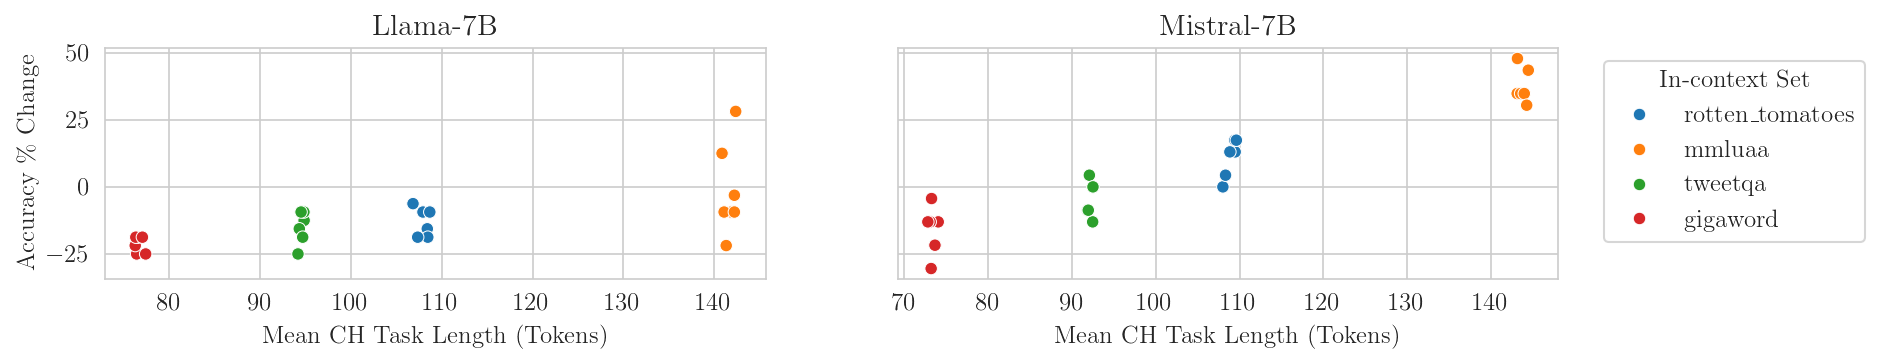

In [ ]:
df = aa_results_df.copy()

# remove num_examples == 0
df = df[df["num_examples"] > 0]
# keep models: llama-7b, mistral-7b
df = df[df["model"].isin(["llama-7b", "mistral-7b"])]

rank_col = "mean_ch_len_1ex"
df[rank_col] = df["mean_conversation_history_length"] / df["num_examples"]

label = r"Accuracy \% Change"
df = df.rename(columns={"acc_pct_change": label})

num_models = len(df["model"].unique())
print(num_models)

fig, axs = plt.subplots(figsize=(12.5, 2), nrows=1, ncols=num_models, sharey=True, squeeze=False)

for idx, (model, df_model) in enumerate(df.groupby("model")):
    sns.scatterplot(data=df_model, x=rank_col, y=label, hue="incontext_set", ax=axs[0, idx])
    axs[0, idx].set_title(model_label[model])
    axs[0, idx].set_xlabel(r"Mean CH Task Length (Tokens)")
    axs[0, idx].legend_.remove()

# sns.scatterplot(data=df, x="mean_ch_len_1ex", y=label, hue="incontext_set", style="model")
plt.legend(title="In-context Set", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
# output table of results
d = df.groupby(["model", "incontext_set"]).mean()
d = d[[label, rank_col]]
d = d.reset_index()
print(markdown_task_distance(d, label, rank_col))

| CH Task | CH Task Length (# Tokens) | Llama-7B | Mistral-7B |
| --- | ---  | --- | --- | --- | --- |
| Gigaword | 75 | -21.35 | -15.94 |
| TweetQA | 93 | -15.10 | -4.35 |
| Rotten Tomatoes | 108 | -13.02 | 10.87 |
| MMLU Abstract Algebra | 143 | -1.79 | 37.68 |



### Length of Conversation vs Accuracy

In [16]:
df

,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length,acc,Accuracy \% Change
0,26,0,100,100,mistral-7b,rotten_tomatoes,3,None,None,None,328.45,136.44,11.11,476.00,0.26,13.043478
1,27,0,100,1000,mistral-7b,rotten_tomatoes,3,None,None,None,328.31,136.44,11.11,475.86,0.27,17.391304
2,23,0,100,10000,mistral-7b,rotten_tomatoes,3,None,None,None,324.05,136.44,11.08,471.57,0.23,0.000000
3,26,0,100,100,mistral-7b,rotten_tomatoes,6,None,None,None,653.10,136.44,11.11,800.65,0.26,13.043478
4,27,0,100,1000,mistral-7b,rotten_tomatoes,6,None,None,None,657.74,136.44,11.11,805.29,0.27,17.391304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,26,3,100,1000,llama-7b,gigaword,6,None,None,None,457.90,134.65,143.02,735.57,0.26,-18.750000
68,26,6,100,10000,llama-7b,gigaword,6,None,None,None,462.27,134.65,140.20,737.12,0.26,-18.750000
69,32,1,100,100,llama-7b,gigaword,0,None,None,None,0.00,134.65,177.87,312.52,0.32,0.000000
70,32,1,100,1000,llama-7b,gigaword,0,None,None,None,0.00,134.65,177.87,312.52,0.32,0.000000


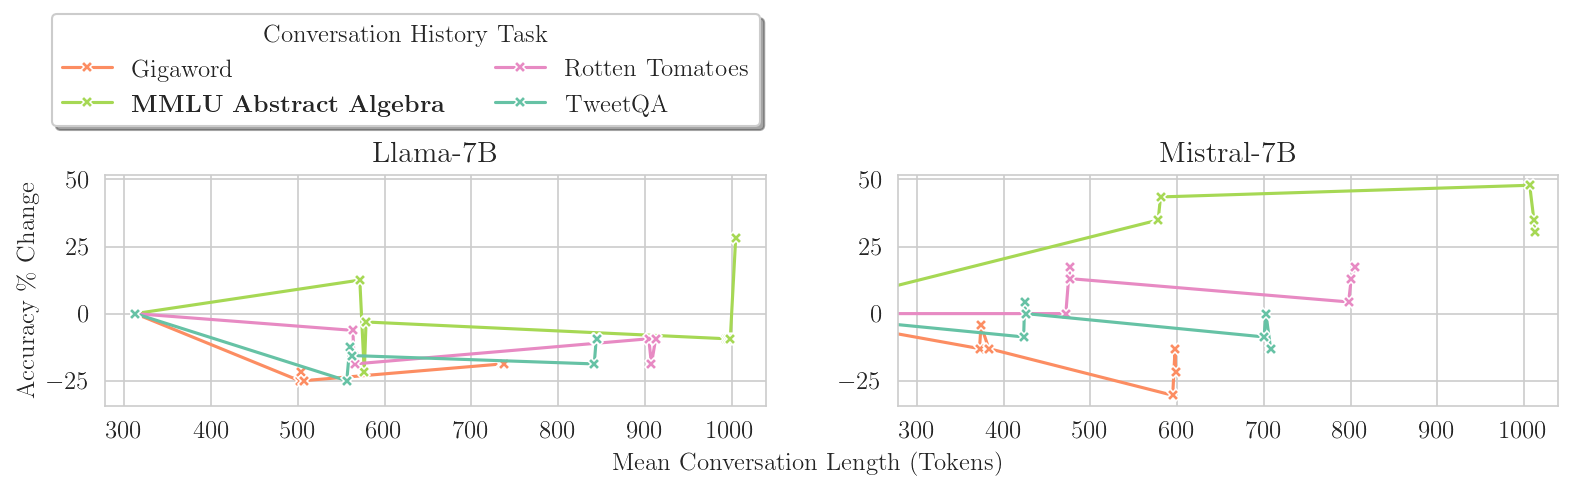

In [153]:
label = r"Accuracy \% Change"
df = aa_results_df.rename(columns={"acc_pct_change": label})
# keep models: llama-7b, mistral-7b
df = df[df["model"].isin(["llama-7b", "mistral-7b"])]
plot_df_metrics_per_model(
  df, 
  [label], 
  # save_path=Path("rt/accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  x="mean_conversation_length",
  eval_set="mmluaa",
  legend_anchor=(-1.3, 1.75),
  xlim=None,
  # adjust_func=lambda axs: axs[0, 0].set_ylim(-7, 4),
  legend_axs=(-1, 1),
  # save_png=True,
  fig_xlabel=r"Mean Conversation Length (Tokens)",
)

### Distance Metric: Format (MCQ, Essay)

MMLU, RT, TweetQA, Gigaword

Results df: num_examples, inctxt, model, (seed), 

In [97]:
df = aa_results_df

df["acc"] = df["matches"] / df["total"]
df = df_metric_pct_change(df, "acc")

# remove num_examples == 0
df = df[df["num_examples"] > 0]

mmlu_ranks = {
  "mmluaa": 1,
  "rotten_tomatoes": 2,
  "tweetqa": 3,
  "gigaword": 4,
}
df["inctxt_rank"] = df["incontext_set"].apply(lambda inctxt: mmlu_ranks[inctxt])
df.head()

/tmp/ipykernel_41368/1501764709.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["inctxt_rank"] = df["incontext_set"].apply(lambda inctxt: mmlu_ranks[inctxt])


,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length,acc,acc_pct_change,inctxt_rank
0,26,0,100,100,mistral-7b,rotten_tomatoes,3,None,None,None,328.45,136.44,11.11,476.00,0.26,13.043478,2
1,27,0,100,1000,mistral-7b,rotten_tomatoes,3,None,None,None,328.31,136.44,11.11,475.86,0.27,17.391304,2
2,23,0,100,10000,mistral-7b,rotten_tomatoes,3,None,None,None,324.05,136.44,11.08,471.57,0.23,0.000000,2
3,26,0,100,100,mistral-7b,rotten_tomatoes,6,None,None,None,653.10,136.44,11.11,800.65,0.26,13.043478,2
4,27,0,100,1000,mistral-7b,rotten_tomatoes,6,None,None,None,657.74,136.44,11.11,805.29,0.27,17.391304,2


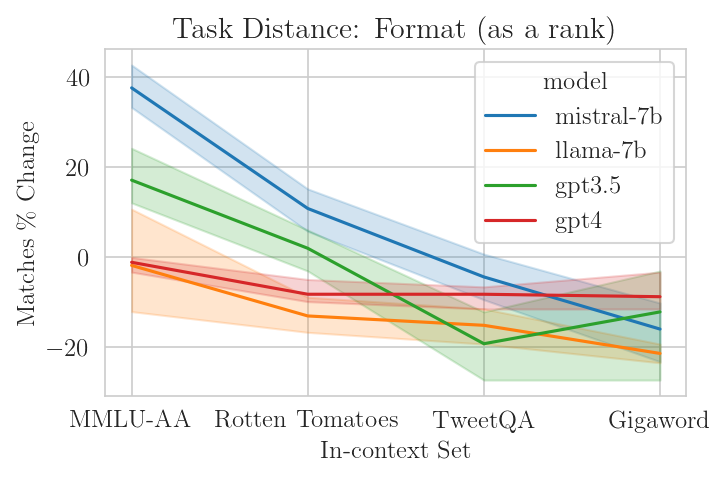

In [99]:
# plot rank against matches_pct_change
fig, ax = plt.subplots(figsize=(5,3))
sns.lineplot(data=df, x="inctxt_rank", y="acc_pct_change", hue="model", ax=ax)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["MMLU-AA", "Rotten Tomatoes", "TweetQA", "Gigaword"])
# rotate xlabels
# plt.xticks(rotation=10)
ax.set_xlabel("In-context Set")
ax.set_ylabel(r"Matches \% Change")
ax.set_title("Task Distance: Format (as a rank)")
plt.show()

In [100]:
metric = "acc_pct_change"
print("Metric: ", metric)
print(markdown_task_distance_rank(aa_results_df, metric, mmlu_ranks))

Metric:  acc_pct_change
| CH Task | Rank | GPT-3.5 | GPT-4 | Llama-7B | Mistral-7B |
| --- | ---  | --- | --- | --- | --- | --- | --- | --- | --- |
| MMLU Abstract Algebra | 1 | 12.88 | -0.82 | -1.14 | 25.12 |
| Rotten Tomatoes | 2 | 1.52 | -6.15 | -8.68 | 7.25 |
| TweetQA | 3 | -14.39 | -6.15 | -10.07 | -2.90 |
| Gigaword | 4 | -9.09 | -6.56 | -14.24 | -10.63 |



### Distance Metric: Length of Incontext Question (by number of tokens)

Options for length of question:
- CH Length

Results df: num_examples, inctxt, model, (seed), 

In [91]:
df.head()

,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length,acc,acc_pct_change,inctxt_rank
0,948,15,1066,100,mistral-7b,rotten_tomatoes,3,None,None,None,327.220450,99.798311,11.084428,438.103189,0.889306,2.597403,1
1,947,15,1066,1000,mistral-7b,rotten_tomatoes,3,None,None,None,325.981238,99.798311,11.209193,436.988743,0.888368,2.489177,1
2,946,14,1066,10000,mistral-7b,rotten_tomatoes,3,None,None,None,327.063790,99.798311,11.121951,437.984053,0.887430,2.380952,1
3,957,11,1066,100,mistral-7b,rotten_tomatoes,6,None,None,None,653.592871,99.798311,11.157598,764.548780,0.897749,3.571429,1
4,954,13,1066,1000,mistral-7b,rotten_tomatoes,6,None,None,None,652.702627,99.798311,11.119137,763.620075,0.894934,3.246753,1


2


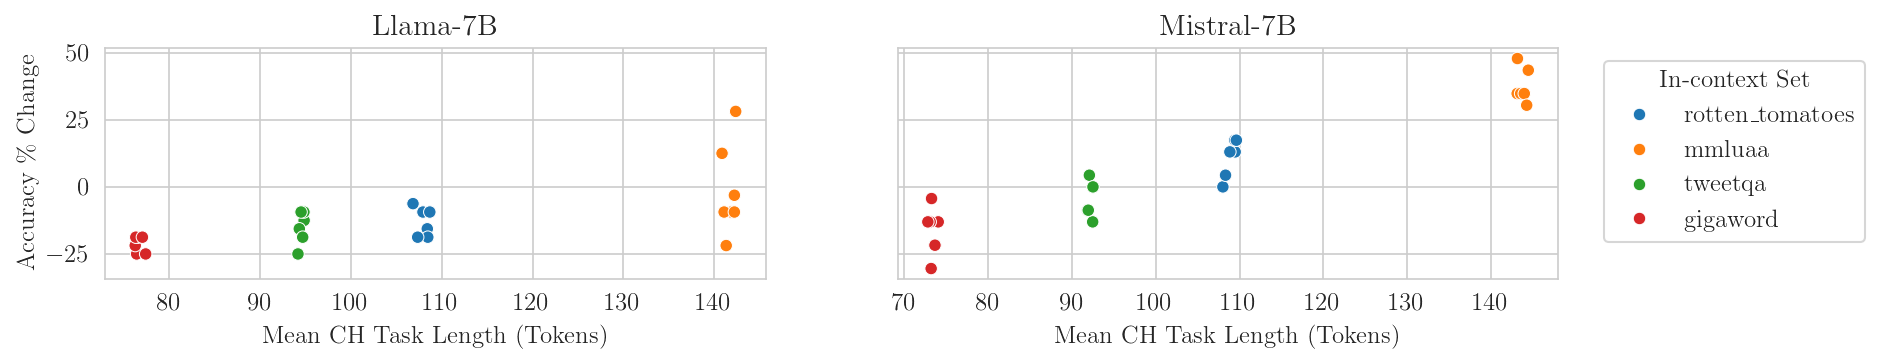

In [110]:
df = aa_results_df.copy()

# remove num_examples == 0
df = df[df["num_examples"] > 0]
# keep models: llama-7b, mistral-7b
df = df[df["model"].isin(["llama-7b", "mistral-7b"])]

rank_col = "mean_ch_len_1ex"
df[rank_col] = df["mean_conversation_history_length"] / df["num_examples"]

label = r"Accuracy \% Change"
df = df.rename(columns={"acc_pct_change": label})

num_models = len(df["model"].unique())
print(num_models)

fig, axs = plt.subplots(figsize=(12.5, 2), nrows=1, ncols=num_models, sharey=True, squeeze=False)

for idx, (model, df_model) in enumerate(df.groupby("model")):
    sns.scatterplot(data=df_model, x=rank_col, y=label, hue="incontext_set", ax=axs[0, idx])
    axs[0, idx].set_title(model_label[model])
    axs[0, idx].set_xlabel(r"Mean CH Task Length (Tokens)")
    axs[0, idx].legend_.remove()

# sns.scatterplot(data=df, x="mean_ch_len_1ex", y=label, hue="incontext_set", style="model")
plt.legend(title="In-context Set", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [152]:
# output table of results
d = df.groupby(["model", "incontext_set"]).mean()
d = d[[label, rank_col]]
d = d.reset_index()
print(markdown_task_distance(d, label, rank_col))

| CH Task | CH Task Length (# Tokens) | Llama-7B | Mistral-7B |
| --- | ---  | --- | --- | --- | --- |
| Gigaword | 75 | -21.35 | -15.94 |
| TweetQA | 93 | -15.10 | -4.35 |
| Rotten Tomatoes | 108 | -13.02 | 10.87 |
| MMLU Abstract Algebra | 143 | -1.79 | 37.68 |

